In [1]:

#this is just for practise purpose




from datetime import datetime, timedelta

# Load data from CSV file
df = pd.read_csv('Ajmer.csv')

# Print column names to check for 'datetime' column
print("Column names in the dataset:", df.columns)

# Convert 'datetime' column to datetime
date_column_name = 'datetime'
df[date_column_name] = pd.to_datetime(df[date_column_name])

def check_heatwave(input_date, df, date_column_name):
    input_date = pd.to_datetime(input_date)
    start_date = input_date - timedelta(days=2)
    end_date = input_date + timedelta(days=2)
    
    # Filter the DataFrame for the range around the input date
    df_filtered = df[(df[date_column_name] >= start_date) & (df[date_column_name] <= end_date)]
    
    if len(df_filtered) < 3:
        return "Not enough data to determine a heatwave"
    
    heatwave = False
    for i in range(len(df_filtered) - 2):
        if (df_filtered.iloc[i]['tempmax'] > 90 and
            df_filtered.iloc[i+1]['tempmax'] > 90 and
            df_filtered.iloc[i+2]['tempmax'] > 90):
            heatwave = True
            break
    
    return "Heatwave" if heatwave else "No heatwave"

# Get user input date
input_date = input("Enter the date (YYYY-MM-DD): ")
result = check_heatwave(input_date, df, date_column_name)
print(result)


NameError: name 'pd' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from itertools import groupby
# Load data
df = pd.read_csv('Ajmer.csv')

# Parse datetime column and set it as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Drop non-numeric and irrelevant columns for the model
df = df.drop(columns=['name', 'conditions', 'icon', 'stations', 'preciptype'])

# Check for missing values
df = df.ffill()  # Forward fill for simplicity

# Separate features and target variable
features = df.drop(columns=['temp'])
target = df['temp']

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Convert target to a numpy array
target = target.values

# Define a function to create sequences
def create_sequences(features, target, time_steps=24):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Create sequences
time_steps = 24  # Number of hours to look back
X, y = create_sequences(scaled_features, target, time_steps)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Define the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, shuffle=False)
# Make predictions
y_pred = model.predict(X_test)

# Reverse the normalization for interpretation
y_test_actual = target[len(target) - len(y_test):]  # Adjust the range as needed
y_pred_actual = y_pred.flatten()

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y_test_actual - y_pred_actual) ** 2))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Temperature')
plt.plot(y_pred_actual, label='Predicted Temperature')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()
# Define heat wave detection parameters
# Define heat wave detection parameters
heat_wave_threshold = 40  # Define your heat wave threshold in degrees Celsius
heat_wave_duration = 48   # Define the duration in hours to consider a heat wave

# Detect heat waves in predictions
heat_wave_pred = y_pred_actual > heat_wave_threshold

# Debug: Print the predicted temperatures and heat wave detection array
print(f"Predicted temperatures: {y_pred_actual}")


print(f"Heat wave detection array: {heat_wave_pred}")

# Detect consecutive hours above threshold
heat_waves = [list(g) for k, g in groupby(heat_wave_pred) if k]

# Debug: Print the grouped heat wave periods
print(f"Grouped heat wave periods: {heat_waves}")

# Print detected heat waves
heat_wave_found = False
for i, heat_wave in enumerate(heat_waves):
    if len(heat_wave) >= heat_wave_duration:
        start_index = sum(map(len, heat_waves[:i]))
        print(f"Heat wave detected: {len(heat_wave)} hours starting from index {start_index}")
        heat_wave_found = True

if not heat_wave_found:
    print("No heat waves detected based on the given threshold and duration.")


ValueError: could not convert string to float: '2024-06-11T05:38:04'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the data from a CSV file
file_path = 'ajmer.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tempmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tempmax > 40, else 0

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, len(features))))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:], 'predicted_heatwave'] = np.concatenate((y_train, predicted_labels)).astype(int)

print(data[['tempmax', 'predicted_heatwave']].tail(10))


Epoch 1/50


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.6480 - val_accuracy: 1.0000 - val_loss: 0.6461
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.6376 - val_accuracy: 1.0000 - val_loss: 0.6374
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.6275 - val_accuracy: 1.0000 - val_loss: 0.6288
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.6173 - val_accuracy: 1.0000 - val_loss: 0.6203
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.6074 - val_accuracy: 1.0000 - val_loss: 0.6118
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.5976 - val_accuracy: 1.0000 - val_loss: 0.6035
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.5880 - val_accuracy: 1.0000 - val_loss: 0.5951
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.5784 - val_accuracy: 1.0000 - val_loss: 0.5867
Epoch 9/50
1/

Mean Squared Error: 0.797873000000007
Temperature on 2024-06-15: 34.30°C
Temperature on 2024-06-16: 35.01°C
Temperature on 2024-06-17: 35.53°C
Temperature on 2024-06-18: 35.36°C
Temperature on 2024-06-19: 34.97°C


C:\Users\subbu\AppData\Local\Temp\ipykernel_3972\97493077.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [ ]:
data=pd.read_csv("delhi100.csv")
    
data.head()

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,1901-01-01,NaN,NaN,NaN,0.0,NaN,NaN
1,1901-01-02,NaN,NaN,NaN,0.0,NaN,NaN
2,1901-01-03,NaN,NaN,NaN,0.0,NaN,NaN
3,1901-01-04,NaN,NaN,NaN,0.0,NaN,NaN
4,1901-01-05,NaN,NaN,NaN,0.0,NaN,NaN


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1667 - loss: 0.7046 - val_accuracy: 0.0000e+00 - val_loss: 0.7008
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5000 - loss: 0.6942 - val_accuracy: 0.0000e+00 - val_loss: 0.6942
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6667 - loss: 0.6905 - val_accuracy: 1.0000 - val_loss: 0.6877
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.6818 - val_accuracy: 1.0000 - val_loss: 0.6811
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.6785 - val_accuracy: 1.0000 - val_loss: 0.6742
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.6665 - val_accuracy: 1.0000 - val_loss: 0.6673
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.6651 - val_accuracy: 1.0000 - val_loss: 0.6603
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.6511 - val_accuracy: 1.0000 - val

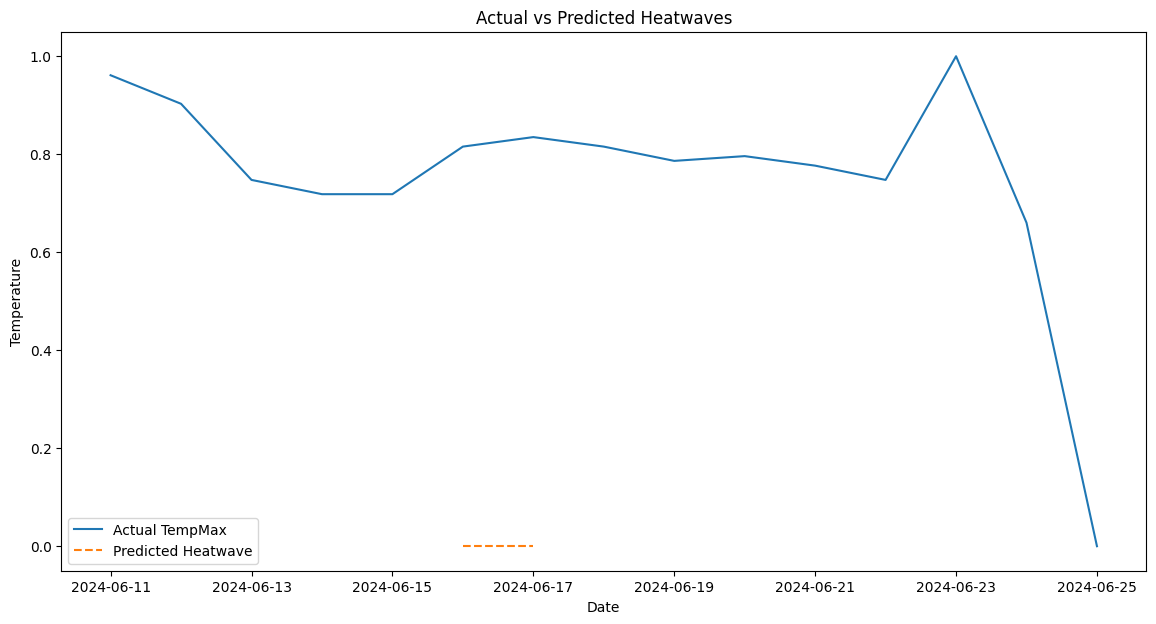

In [ ]:
#tryna do somthng
from datetime import datetime
from dateutil import parser
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'ajmer.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']
date_input = input("Enter a date (YYYY-MM-DD): ")

# Parse the date input into a datetime object
try:
    user_date = parser.parse(date_input).date()
except ValueError:
    print("Invalid date format. Please enter date in YYYY-MM-DD format.")
    exit()

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tempmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tempmax > 40, else 0

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the enhanced LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves based on user input dates
def predict_heatwave_for_dates(dates):
    new_data = data.loc[dates]
    new_data_scaled = scaler.transform(new_data[features])
    
    # Create sequences from the new data
    new_sequences = []
    for i in range(len(new_data_scaled) - seq_length):
        seq = new_data_scaled[i:i + seq_length]
        new_sequences.append(seq)
    
    new_sequences = np.array(new_sequences)
    
    # Predict heatwaves
    new_predictions = model.predict(new_sequences)
    new_predicted_labels = (new_predictions > 0.5).astype(int).flatten()
    
    result = pd.DataFrame({
        'date': new_data.index[seq_length:],
        'predicted_heatwave': new_predicted_labels,
        'tempmax': new_data['tempmax'][seq_length:],
        'temp': new_data['temp'][seq_length:],
        'humidity': new_data['humidity'][seq_length:]
    })
    
    return result

# Example usage with user input dates
user_dates = pd.date_range(start='2024-06-16', end='2024-06-25')
prediction_result = predict_heatwave_for_dates(user_dates)
print(prediction_result)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tempmax'], label='Actual TempMax')
valid_predictions = data['predicted_heatwave'].dropna()
plt.plot(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Heatwaves')
plt.legend()
plt.show()
model.save("lstmtest.h5")


Epoch 1/100


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.6703 - val_accuracy: 1.0000 - val_loss: 0.6550
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.6566 - val_accuracy: 1.0000 - val_loss: 0.6428
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.6477 - val_accuracy: 1.0000 - val_loss: 0.6295
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.6462 - val_accuracy: 1.0000 - val_loss: 0.6158
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.6317 - val_accuracy: 1.0000 - val_loss: 0.6015
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.6094 - val_accuracy: 1.0000 - val_loss: 0.5866
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.6024 - val_accuracy: 1.0000 - val_loss: 0.5710
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.6034 - val_accuracy: 1.0000 - val_loss: 0.5546
Epoch 

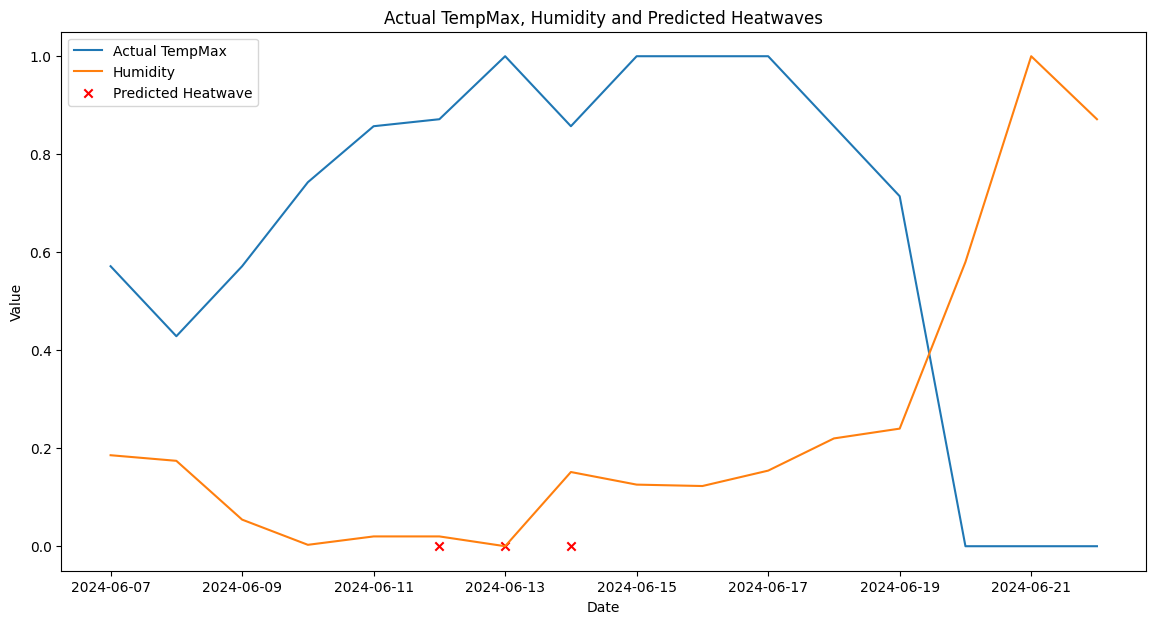

In [2]:
from datetime import datetime
from dateutil import parser
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'delhi100cleaned.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']
date_input = input("Enter a date (YYYY-MM-DD): ")

# Parse the date input into a datetime object
try:
    user_date = parser.parse(date_input).date()
except ValueError:
    print("Invalid date format. Please enter date in YYYY-MM-DD format.")
    exit()

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tempmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tempmax > 40, else 0

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the enhanced LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Visualize the learning curves
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves based on user input dates
def predict_heatwave_for_dates(dates):
    # Ensure all requested dates are in the DataFrame
    valid_dates = [date for date in dates if date in data.index]
    if not valid_dates:
        print("No valid dates found in the data.")
        return pd.DataFrame()  # Return an empty DataFrame if no valid dates

    new_data = data.loc[valid_dates]
    new_data_scaled = scaler.transform(new_data[features])
    
    # Create sequences from the new data
    new_sequences = []
    for i in range(len(new_data_scaled) - seq_length):
        seq = new_data_scaled[i:i + seq_length]
        new_sequences.append(seq)
    
    if not new_sequences:
        print("Not enough data to create sequences.")
        return pd.DataFrame()  # Return an empty DataFrame if not enough data
    
    new_sequences = np.array(new_sequences)
    
    # Predict heatwaves
    new_predictions = model.predict(new_sequences)
    new_predicted_labels = (new_predictions > 0.5).astype(int).flatten()
    
    result = pd.DataFrame({
        'date': new_data.index[seq_length:],
        'tempmax': new_data['tempmax'][seq_length:],
        'temp': new_data['temp'][seq_length:],
        'humidity': new_data['humidity'][seq_length:],
        'predicted_heatwave': new_predicted_labels
    })
    
    result['heatwave'] = result['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    
    return result

# Example usage with user input dates
user_dates = pd.date_range(start='2024-06-16', end='2024-06-25')
prediction_result = predict_heatwave_for_dates(user_dates)
print(prediction_result)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tempmax'], label='Actual TempMax')
plt.plot(data.index, data['humidity'], label='Humidity')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual TempMax, Humidity and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


KeyError: 'datetime'

Epoch 1/100


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.6826 - val_accuracy: 1.0000 - val_loss: 0.6672
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.6751 - val_accuracy: 1.0000 - val_loss: 0.6596
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.6718 - val_accuracy: 1.0000 - val_loss: 0.6517
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.6607 - val_accuracy: 1.0000 - val_loss: 0.6435
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.6547 - val_accuracy: 1.0000 - val_loss: 0.6352
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.6568 - val_accuracy: 1.0000 - val_loss: 0.6268
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.6422 - val_accuracy: 1.0000 - val_loss: 0.6183
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.6368 - val_accuracy: 1.0000 - val_loss: 0.6099
Epoch 

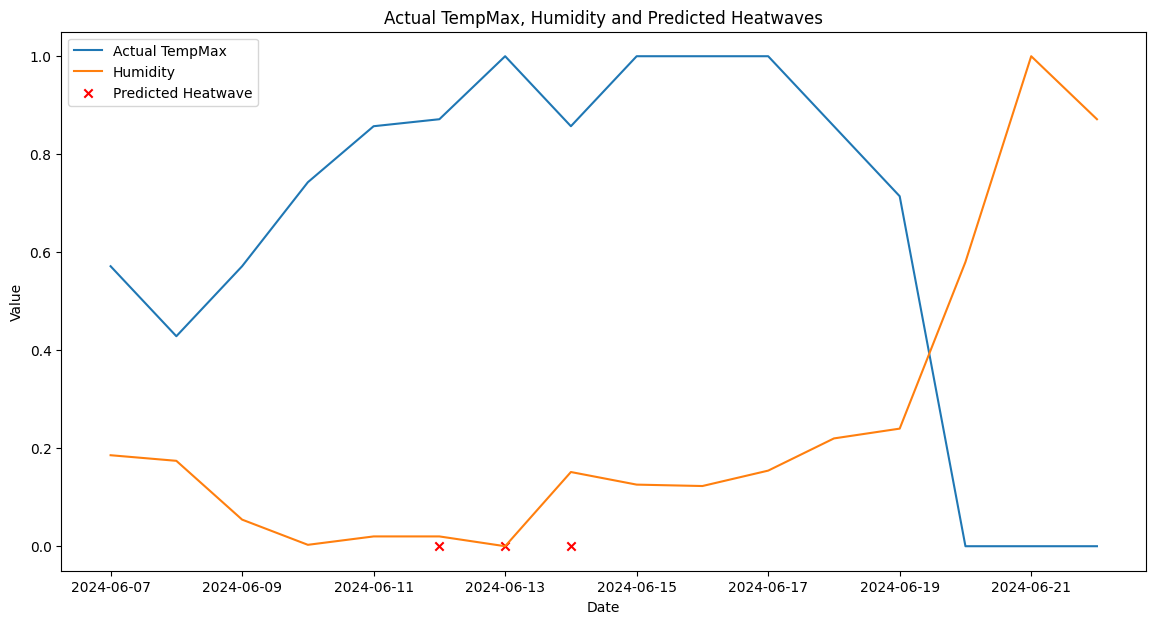

In [ ]:
from datetime import datetime
from dateutil import parser
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'delhi15.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
features = ['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']
date_input = input("Enter a date (YYYY-MM-DD): ")

# Parse the date input into a datetime object
try:
    user_date = parser.parse(date_input).date()
except ValueError:
    print("Invalid date format. Please enter date in YYYY-MM-DD format.")
    exit()

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['tempmax']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if tempmax > 40, else 0

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the enhanced LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves based on user input dates
def predict_heatwave_for_dates(dates):
    # Ensure all requested dates are in the DataFrame
    valid_dates = [date for date in dates if date in data.index]
    if not valid_dates:
        print("No valid dates found in the data.")
        return pd.DataFrame()  # Return an empty DataFrame if no valid dates

    new_data = data.loc[valid_dates]
    new_data_scaled = scaler.transform(new_data[features])
    
    # Create sequences from the new data
    new_sequences = []
    for i in range(len(new_data_scaled) - seq_length):
        seq = new_data_scaled[i:i + seq_length]
        new_sequences.append(seq)
    
    if not new_sequences:
        print("Not enough data to create sequences.")
        return pd.DataFrame()  # Return an empty DataFrame if not enough data
    
    new_sequences = np.array(new_sequences)
    
    # Predict heatwaves
    new_predictions = model.predict(new_sequences)
    new_predicted_labels = (new_predictions > 0.5).astype(int).flatten()
    
    result = pd.DataFrame({
        'date': new_data.index[seq_length:],
        'tempmax': new_data['tempmax'][seq_length:],
        'temp': new_data['temp'][seq_length:],
        'humidity': new_data['humidity'][seq_length:],
        'predicted_heatwave': new_predicted_labels
    })
    
    result['heatwave'] = result['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    
    return result

# Example usage with user input dates
user_dates = pd.date_range(start='2024-06-16', end='2024-06-25')
prediction_result = predict_heatwave_for_dates(user_dates)
print(prediction_result)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tempmax'], label='Actual TempMax')
plt.plot(data.index, data['humidity'], label='Humidity')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual TempMax, Humidity and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


In [ ]:
#tryna test
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Example dataset (replace this with your actual dataset)


# Example LSTM model (replace with your actual trained model loading code)
# Assume 'model' is your trained LSTM model
# Replace with your actual model loading code
from keras.models import load_model
model = load_model('lstmtest.h5')  # Replace with your actual model path

# Function to preprocess data for LSTM prediction
def preprocess_data(df, seq_length):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    X = []
    y = []
    for i in range(seq_length, len(df_scaled)):
        X.append(df_scaled.iloc[i-seq_length:i].values)
        y.append(df_scaled.iloc[i]['heatwave'])  # Assuming 'heatwave' is the target column
    return np.array(X), np.array(y), scaler

# Parameters
seq_length = 10  # Sequence length for LSTM
threshold = 0.5  # Threshold for predicting heatwave

# Example usage of accepting a date from the user
date_input = input("Enter a date (YYYY-MM-DD): ")

# Parse the date input into a datetime object
try:
    user_date = parser.parse(date_input).date()
except ValueError:
    print("Invalid date format. Please enter date in YYYY-MM-DD format.")
    exit()

print("User entered date:", user_date)

# Filter data for the user-entered date
input_features = data[data['date'].dt.date == user_date]

# Check if the date exists in your dataset
if input_features.empty:
    print("Data for the entered date is not available.")
    exit()

# Extract the relevant features for prediction
new_data = input_features[['tempmax', 'tempmin', 'temp', 'humidity', 'windspeed', 'sealevelpressure']]

print("Input features for prediction:")
print(new_data)

# Predict the heatwave probability
X_new = new_data.values.reshape(1, -1, new_data.shape[1])
predicted_heatwave = model.predict(X_new)

print("Predicted Heatwave Probability:", predicted_heatwave[0])

# Interpret the prediction
if predicted_heatwave[0] >= threshold:
    print("There is a predicted heatwave.")
else:
    print("No predicted heatwave.")

# Plotting actual vs predicted temperature (example)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tempmax'], label='Actual TempMax')
plt.plot(input_features.index, input_features['tempmax'], 'ro', label='Input Date TempMax')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual and Input Date Temperature')
plt.legend()
plt.show()


User entered date: 2024-12-12


KeyError: 'date'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('Ajmer.csv')

# Parse datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day

# Handle missing values by filling with median
for column in data.select_dtypes(include=np.number).columns:
    data[column].fillna(data[column].median(), inplace=True)

# Convert categorical data to numeric
categorical_columns = ['conditions', 'description', 'icon', 'preciptype', 'stations']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Feature and target variables
features = data.drop(columns=['temp', 'datetime'])
target = data['temp']

# Ensure all features are numeric
features = features.apply(pd.to_numeric, errors='coerce')
features = features.fillna(0)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Hyperparameter Tuning with Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Removed 'auto'
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, error_score='raise')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

# Evaluate the Model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Cross-validation scores
cv_scores = cross_val_score(best_model, features, target, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {np.mean(cv_scores)}')

# Predict Future Temperatures
def predict_future_temperature(model, data, start_date, days_ahead=5):
    start_date = pd.to_datetime(start_date)
    predictions = []
    
    for i in range(days_ahead):
        current_date = start_date + pd.Timedelta(days=i)
        feature_row = data[data['datetime'] == current_date].drop(columns=['temp', 'datetime'])
        if feature_row.empty:
            print(f"No data available for {current_date}")
            break
        feature_row = feature_row.apply(pd.to_numeric, errors='coerce').fillna(0)
        prediction = model.predict(feature_row)
        predictions.append((current_date, prediction[0]))
    
    return predictions

# Predict temperatures for the next 5 days from a given date
start_date = '2024-06-15'
future_temperatures = predict_future_temperature(best_model, data, start_date)
for date, temp in future_temperatures:
    print(f'Temperature on {date.date()}: {temp:.2f}°C')


KeyError: 'datetime'

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'dc100.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Select relevant columns and convert the datetime column
data['Date'] = pd.to_datetime(data['Date'], format="%yy-%mm-%dd")
data.set_index('Date', inplace=True)
features = ['TAVG (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 'PRCP (Inches)']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['TMAX (Degrees Fahrenheit)']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if TMAX > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence
        new_entry = np.zeros((1, len(features)))  # Placeholder for new entry
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['TMAX (Degrees Fahrenheit)'], label='Actual TMAX')
plt.plot(data.index, data['PRCP (Inches)'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual TMAX, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")


ValueError: time data "1901-01-01" doesn't match format "%yy-%mm-%dd", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
data=pd.read_csv("delhi100.csv")
data.head()
print(data)

                                                                                                                     AJMER, IN (IN019010300)
Date       TAVG (Degrees Fahrenheit) TMAX (Degrees Fahrenheit) TMIN (Degrees Fahrenheit) PRCP (Inches) SNOW (Inches)           SNWD (Inches)
1901-01-01 NaN                       NaN                       NaN                       0.00          NaN                               NaN
1901-01-02 NaN                       NaN                       NaN                       0.00          NaN                               NaN
1901-01-03 NaN                       NaN                       NaN                       0.00          NaN                               NaN
1901-01-04 NaN                       NaN                       NaN                       0.00          NaN                               NaN
...                                                                                                                                      ...
2024-06-04 99

Index(['Date', 'TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)',
       'TMIN (Degrees Fahrenheit)', 'PRCP (Inches)', 'SNOW (Inches)',
       'SNWD (Inches)'],
      dtype='object')


C:\Users\subbu\AppData\Local\Temp\ipykernel_7568\3675329339.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8482 - loss: 0.3252 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 2/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 8.3906e-04
Epoch 3/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 6.7134e-04 - val_accuracy: 1.0000 - val_loss: 3.2141e-04
Epoch 4/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 2.7227e-04 - val_accuracy: 1.0000 - val_loss: 1.5213e-04
Epoch 5/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 1.3218e-04 - val_accuracy: 1.0000 - val_loss: 7.9700e-05
Epoch 6/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 7.0194e-05 - val_accuracy: 1.0000 - val_loss: 4.4073e-05
Epoch 7/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 3.9191e-05 - val_accuracy: 1.0000 - val_loss: 2.5325e-05
Epoch 8/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accura

C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
        date  predicted_heatwave heatwave
0 2024-06-09                   1      Yes
1 2024-06-10                   1      Yes
2 2024-06-11                   1      Yes
3 2024-06-12                   1      Yes
4 2024-06-13                   1      Yes


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


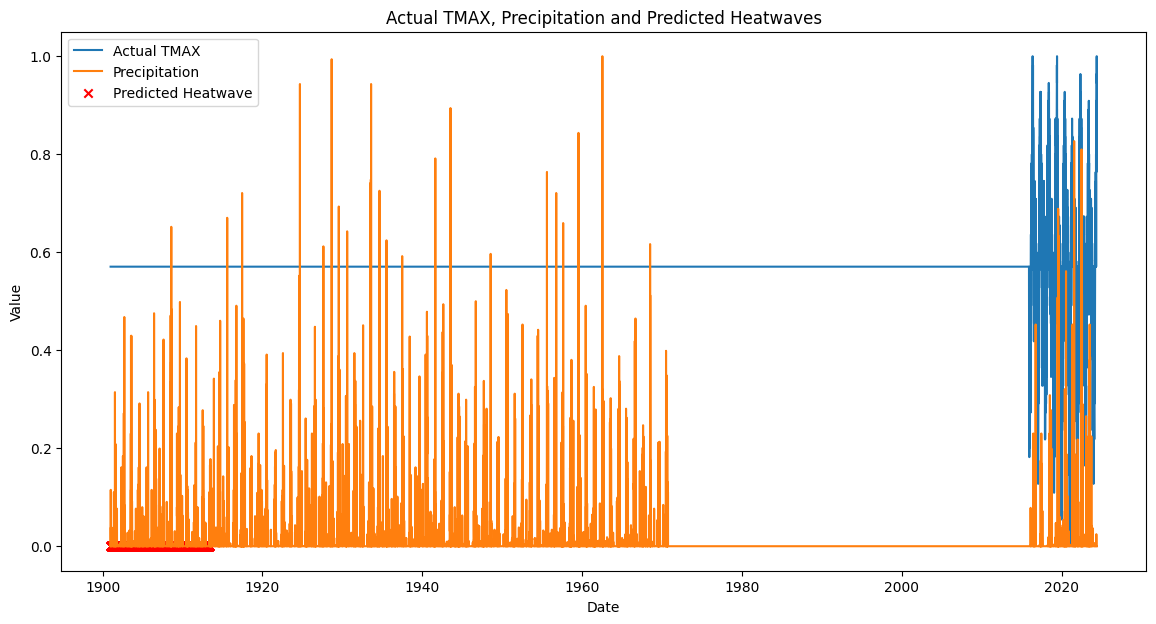

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data from a CSV file
file_path = 'dc100.csv'  # Update this path to where you saved the CSV
data = pd.read_csv(file_path)

# Print the columns to verify the correct names
print(data.columns)

# Select relevant columns and convert the datetime column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Handle missing values by filling them (you could also use other methods like interpolation)
data.fillna(method='ffill', inplace=True)

# Select features
features = ['TAVG (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 'PRCP (Inches)']

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences for LSTM input
def create_sequences(data, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][features].values
        label = data.iloc[i + seq_length]['TMAX (Degrees Fahrenheit)']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 5
X, y = create_sequences(data, seq_length)
y = (y > 40).astype(int)  # Label as 1 if TMAX > 40, else 0

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model with enhanced regularization
def build_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_acc = []

for train_index, val_index in kfold.split(X_train):
    model = build_model()
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])
    
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold)
    cross_val_acc.append(accuracy)

average_cross_val_acc = np.mean(cross_val_acc)
print(f'Average Cross-Validation Accuracy: {average_cross_val_acc*100:.2f}%')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict future heatwaves
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to the dataframe
data['predicted_heatwave'] = np.nan
data.loc[data.index[seq_length:seq_length+len(predicted_labels)], 'predicted_heatwave'] = predicted_labels

# Function to predict heatwaves for the next 5 days after the last date in the data
def predict_future_heatwaves(data, model, scaler, features, seq_length=5, days=5):
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days)

    last_seq = data[features].iloc[-seq_length:].values
    future_predictions = []

    for i in range(days):
        seq = scaler.transform(last_seq)
        seq = np.expand_dims(seq, axis=0)
        prediction = model.predict(seq)
        predicted_label = (prediction > 0.5).astype(int).flatten()[0]
        future_predictions.append(predicted_label)
        
        # Create next sequence
        new_entry = np.zeros((1, len(features)))  # Placeholder for new entry
        last_seq = np.vstack([last_seq[1:], new_entry])
        
    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_heatwave': future_predictions
    })

    future_df['heatwave'] = future_df['predicted_heatwave'].apply(lambda x: 'Yes' if x == 1 else 'No')
    return future_df

# Predict heatwaves for the next 5 days
future_heatwaves = predict_future_heatwaves(data, model, scaler, features, seq_length, days=5)
print(future_heatwaves)

# Plot actual vs predicted heatwaves
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['TMAX (Degrees Fahrenheit)'], label='Actual TMAX')
plt.plot(data.index, data['PRCP (Inches)'], label='Precipitation')
valid_predictions = data['predicted_heatwave'].dropna()
plt.scatter(valid_predictions.index, valid_predictions * 40, label='Predicted Heatwave', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual TMAX, Precipitation and Predicted Heatwaves')
plt.legend()
plt.show()

# Save the model
model.save("lstmtest.h5")
